# Fast & slow modes

Volem resoldre el problema dels modes ràpid i lent de les equacios obtingudes a partir de la MHD ideal i de la linealització i posterior adimensionalització de les equacions.

Number of unknowns: 6
Number of equations: 6
(<dedalus.core.subsystems.Subproblem object at 0x130b3d760>,)
2025-04-16 19:17:16,733 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 3s, Remaining: 0s, Rate: 3.7e-01/s


/var/folders/pr/429w6vjs7g15jgb94g5_03_40000gn/T/ipykernel_14949/2535300924.py:158: RuntimeWarning: invalid value encountered in divide
  ug = (u['g'] / u['g'][1]).real
/var/folders/pr/429w6vjs7g15jgb94g5_03_40000gn/T/ipykernel_14949/2535300924.py:174: RuntimeWarning: invalid value encountered in divide
  wg = (w['g'] / w['g'][1]).real


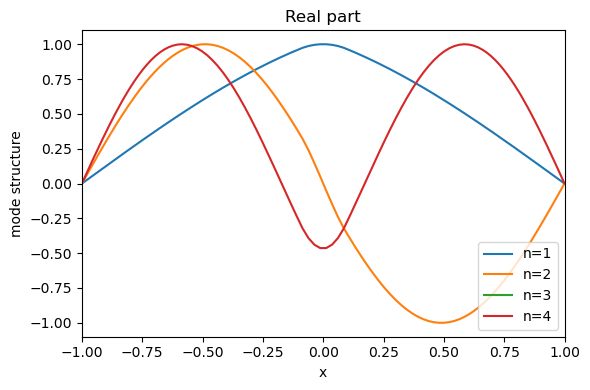

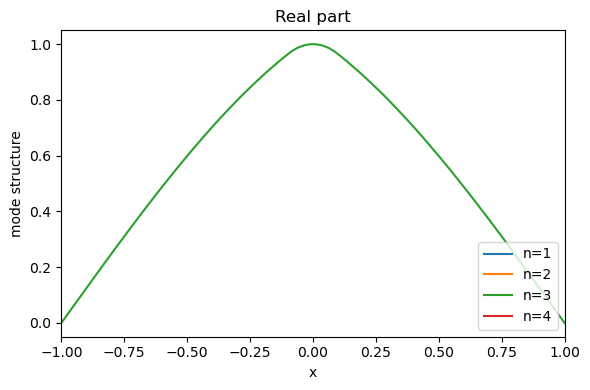

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)



""" Paràmetres """
Nx = 128 # amb 32 ja no és smooth...
dtype = np.complex128 # malla en la que es treballa: 128 complexes, ja que hem definit Nx = 128



""" Límits del domini """
xmax = 1
xmin = -1 # = -xmax
# Position of boundaries between different parts of the system (prominence and corona).
xp = 0.1
# xc ∈ [-1, -0.1], xc ∈ [0.1, 1]
# Square of the wave velocity in the two parts of the system.
cp2 = 1
cc2 = 6
vAp2 = 10
vAc2 = 60
# And the Alfvén speed too.


""" Bases """
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.Legendre(xcoord, size=Nx, bounds=(xmin, xmax)) # Definim una base amb uns altres límits. Chebyshev menos error?



""" Camps """
### Velocitats ### --- autofuncions?
u = dist.Field(name='u', bases=xbasis) # u = field of the wave function - AUTOFUNCIÓ!!! - v10x bar, coplexa
w = dist.Field(name='w', bases=xbasis) # w = Velocity in the x direction   v10z - real
# Definesc la velocitat com en oceano: (u,v,w) per no liar subíndexos i derivades.

### Constants ###
c2 = dist.Field(name='c2', bases=xbasis) # c2 = Velocitat al quadrat ----- és interessant definir-la directament al quadrat ja que és un camp i així evitam fer c.evaluate()**2
c2['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [cc2, cp2, cc2]) # Representa la c^2 en l'espai real ('g') a trossos.
vA2 = dist.Field(name='vA2', bases=xbasis) # vA2 = Alfven velocity squared
vA2['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [vAc2, vAp2, vAc2]) # Representa la velocitat d'Alfven en l'espai real ('g') a trossos.
kz = dist.Field(name='kz', bases=xbasis) # kz = Wave number in the z direction

### Auxiliars de les derivades ###
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
tau_3 = dist.Field(name='tau_3')
tau_4 = dist.Field(name='tau_4')
tau_5 = dist.Field(name='tau_5')

### Autovalors ###
s = dist.Field(name='s') # AUTOVALOR ω^2 = s

### Espai real ###
x = dist.local_grid(xbasis) # PUNTS DEL DOMINI!!!

### Camps magnètics ###
Bx = dist.Field(name='Bx', bases=xbasis) # Bx = Magnetic field in the x direction   B10x
Bz = dist.Field(name='Bz', bases=xbasis) # Bz = Magnetic field in the z direction   B10z
B0 = dist.Field(name='B0', bases=xbasis) # B0 = Constant magnetic

### Densitats ###
rho0 = dist.Field(name='rho0', bases=xbasis) # rho0 = Density of the plasma

rho10 = dist.Field(name='rho10', bases=xbasis) # rho = Variation density of the plasma   ρ10
rho10['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [1, 1, 1]) # Representa la densitat en l'espai real ('g') a trossos.

# Definir bé la densitat...



""" Substitucions """
### Derivades espacials ###
dx = lambda A: d3.Differentiate(A, xcoord) # Derivative operator
lift_basis = xbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
ux = dx(u) + lift(tau_1) # First-order reduction of the velocity in the x direction
uxx = dx(ux) + lift(tau_2) # Second-order reduction of the velocity in the x direction
wx = dx(w) + lift(tau_3) # First-order reduction of the velocity in the z direction
wxx = dx(wx) + lift(tau_4) # Second-order reduction of the velocity in the z direction
rho10x = dx(rho10) +  lift(tau_5) # First-order reduction of the density variation ### realment no és necessari ja que amb l'ajuda de l'equació (12) s'elimina aquesta derivada.
# No és convenient posar directament dx(u) a l'equació ja que faltaria el lift... s'ha de definir bé la derivada
# No definim derivada temporal ja que és un EVP!!!


# RESOLDRE PRIMER SUBSTITUINT BX, BZ i RHO i només resolent 2 eqs... i 4 eqs de contorn, només resolem per u i w


# tenim v_alfven i cp que primer constants i després piecewice


# velocitat dedins menor que defora
# alfven major primer, després provar

# comparar amb kz = 0 les dues equacions han de ser iguals!! recuperam el cas alfven? la de alfven és com la corda directament amb densitat no const.
# provar amb kz = 0.01 i s'ha de modificar poc


""" Problem """
# Problema d'ones ràpides i lentes
#problem = d3.EVP([u, w, Bx, Bz, rho0, rho10, tau_1, tau_2,], eigenvalue=s, namespace=locals())
#problem.add_equation("np.sqrt(s)*rho10 + rho0*(-wx - kz*w) =0 ") # (12)
#problem.add_equation("np.sqrt(s)*Bx = kz*B0*w") # (14)
#problem.add_equation("np.sqrt(s)*Bz = B0*ux") # (16)
#problem.add_equation("np.sqrt(s)*rho10*ux = -c2*rho10x ") # (17)
#problem.add_equation("np.sqrt(s)*rho10*w - c2*kz*rho10 - vA2*(rho/B0)*(kz*Bx -Bzx) = 0") # (19)

# 2 equacions i 4 incògnites
problem = d3.EVP([u, w, tau_1, tau_2, tau_3, tau_4], eigenvalue=s, namespace=locals())

# Problema d'ones d'Alfvén ~ corda guitarra amb densitat variable
#problem.add_equation("s * u  +  vA2 * uxx  =  0") # (12)
#problem.add_equation("s * u  +  c2 * uxx +  kz * c2 * wx  =  0") # (17')
problem.add_equation("s * u  +  c2 * uxx  =  0") # (17')
problem.add_equation("s * w  +  vA2 * wxx  =  0") # (19') # amb kz = 0 hauríem d'obtenir una molt semblant a la (17'), amb la velocitat en z, la constant d'Alfvén i un signe girat?
# SIGNEEEE!!!
problem.add_equation("u(x=xmin) = 0")
problem.add_equation("u(x=xmax) = 0")
problem.add_equation("w(x=xmin) = 0")
problem.add_equation("w(x=xmax) = 0")
#problem.add_equation("kz = 0")


# Problema d'una corda amb densitat variable
# problem = d3.EVP([u,tau_1, tau_2,], eigenvalue=s, namespace=locals())
# problem.add_equation("s*u + c2 * uxx = 0")
# problem.add_equation("u(x=xmin) = 0")
# problem.add_equation("u(x=xmax) = 0")


# Falten definir les equacions de la densitat, el camp magnètic, la velocitat, etc. Per això dona error.
print("Number of unknowns:", len(problem.variables))
print("Number of equations:", len(problem.equations))
#print("Eivdentment no es pot resoldre el problema amb 3 equacions i 8 incògnites.")



""" Solve """
solver = problem.build_solver()
print(solver.subproblems)
solver.solve_dense(solver.subproblems[0])
evals = np.sort(solver.eigenvalues)
n = 1 + np.arange(evals.size)
true_evals = (n * np.pi / 2*xmax)**2
relative_error = np.abs(evals - true_evals) / true_evals


""" Plot """
# Plot real part
plt.figure(figsize=(6, 4))
x = dist.local_grid(xbasis) # no acab d'entendre perquè es repeteix el domini... per si l'has tuneat penmig maybe
for n, idx in enumerate(np.argsort(solver.eigenvalues)[:4], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ug = (u['g'] / u['g'][1]).real
    plt.plot(x, ug/np.max(np.abs(ug)), label=f"n={n}")
plt.xlim(-1, 1)
plt.legend(loc="lower right")
plt.ylabel(r"mode structure")
plt.xlabel(r"x")
plt.title("Real part of v_10x(bar)") # idò és imaginària
plt.tight_layout()
# plt.savefig("eigenvectors.pdf")
# plt.savefig("eigenvectors.png", dpi=200)

# Plot real part
plt.figure(figsize=(6, 4))
x = dist.local_grid(xbasis)
for n, idx in enumerate(np.argsort(solver.eigenvalues)[:4], start=1):
    solver.set_state(idx, solver.subsystems[0])
    wg = (w['g'] / w['g'][1]).real
    plt.plot(x, wg/np.max(np.abs(wg)), label=f"n={n}")
plt.xlim(-1, 1)
plt.legend(loc="lower right")
plt.ylabel(r"mode structure")
plt.xlabel(r"x")
plt.title("Real part ox v_10z")
plt.tight_layout()
# plt.savefig("eigenvectors.pdf")
# plt.savefig("eigenvectors.png", dpi=200)


# A l'hora de representar la part real de les autofuncions has de tenir clar que la velocitat u és en la direcció x i la w en z.
# A més, el que es representa és la velocitat, no la corda en sí. Llavors un node implica velocitat nul·la, llavors aquell punt no es mou.
# Els màxims i mínims són els punts on la velocitat és màxima, no és que la corda es deformi amb aquella forma.


In [ ]:
# Lluc gràfiques amb Times New Roman